# Project 3: Percolation - FYS4460
Author: Øyvind Sigmundson Schøyen

In this project we'll explore _percolation_ from the project shown here: https://www.uio.no/studier/emner/matnat/fys/FYS4460/v19/notes/project2017-ob3.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spi
import skimage
import tqdm

## Computing the density of spanning clusters

We call $P(p, L)$ the _density of spanning clusters._ It is defined as the probability for a site to belong to a _spanning cluster._ A spanning cluster is defined as a cluster having an extent over the entire system size along one axis. We compute the density by extracting all spanning clusters from a system and then counting all the set sites in the spanning clusters. Dividing the number of set sites contained in all the spanning clusters by the total number of sites we find $P(p, L)$.

In [2]:
def compute_density_of_spanning_clusters(system):
    num_rows, num_cols = system.shape
    total_mass = num_rows * num_cols

    # Label and count the number of connected clusters
    labels, num_features = spi.measurements.label(system)
    # Collect regions
    props = skimage.measure.regionprops(labels)
    num_percolating = 0
    mass = 0

    # Iterate through regions and check if they span the entire system
    for prop in props:
        min_row, min_col, max_row, max_col = prop.bbox

        if max_row - min_row == num_rows or max_col - min_col == num_cols:
            num_percolating += 1
            mass += prop.area

    return mass / total_mass

The function `compute_density_of_spanning_clusters` takes in a system and computes the density of spanning clusters, $P(p, L)$. It is general in the sense that it does not distinguish between quadratic or rectangular systems. Below we plot $P(p, L)$ for different $L$ and $p$.

100%|██████████| 101/101 [00:07<00:00, 12.81it/s]


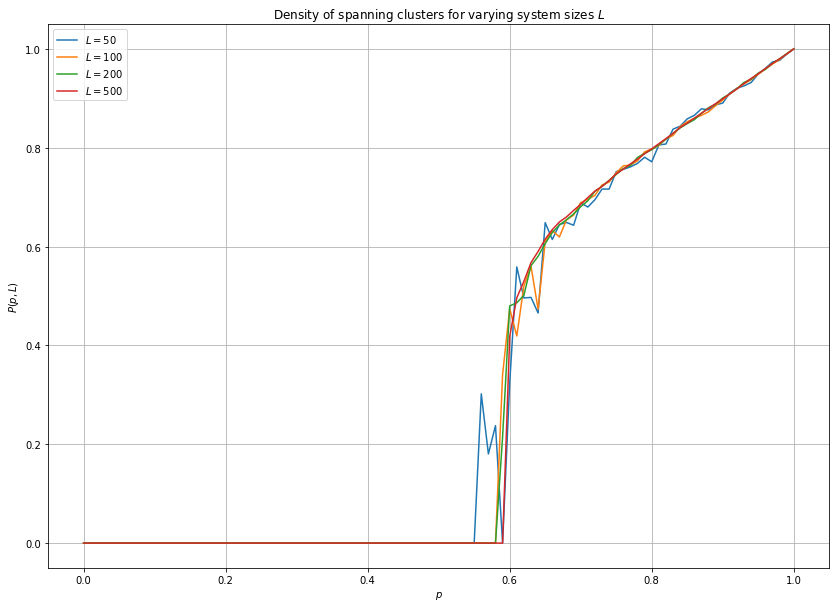

In [3]:
num_systems = 101
p_arr = np.linspace(0, 1, num_systems)

plt.figure(figsize=(14, 10))

for L in [50, 100, 200, 500]:
    density_arr = np.zeros_like(p_arr)
    num_rows = L
    num_cols = L

    for i in tqdm.tqdm(range(num_systems)):
        p = p_arr[i]
        system = np.random.choice([0, 1], size=(num_rows, num_cols), p=[1 - p, p])
        density_arr[i] = compute_density_of_spanning_clusters(system)

    plt.plot(p_arr, density_arr, label=fr"$L = {L}$")


plt.legend(loc="best")
plt.xlabel(r"$p$")
plt.ylabel(r"$P(p, L)$")
plt.grid()
plt.title(r"Density of spanning clusters for varying system sizes $L$")
plt.show()

Here we can see the expected behaviour of the density of spanning clusters as a function of the probability $p$. At $p = p_c \approx 0.59$ the density increases almost step-wise before taking on a linear shape.